## ABM prototype

In [1]:
import agent as ag
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## How agents work

Agents have three characteristics:

1. **features**, immutable variables (e.g., gender, age, etc)
2. **states**, mutable variables (e.g., employed, infected, mental health and number of contacts)
3. **actions**, functions which change the agents' status (e.g., go to work, socialise)

## How a simulation works

Every day an agent can choose an action (ideally multiple actions a day). The simulation will start from day = 0 up until max(steps). At every step, it will check the type of agents' features -> states and thus choices and will apply some lockdown policies. These policies will affect the agents' availability of actions and therefore their states.

We will collect the output of those states as a dataframe every step, i.e., every day.

### Generate a population with given paramenters

We build a population of n agents with the following parameters:

In [2]:
parameters = {'n' : 50,
              'n_age_groups':4,
              'min_age':24,
              'max_age': 65,
              'age_strata': [.25, .23, .31, .21],
              'low_education': .11,
              'medium_education': .25,
              'high_education': .64,
              'employed_true': .86,
              'employed_false_seeking': .055,
              'employed_false_other': .085,
              'single': .20,
              'married': .41,
              'live_in_partner': .29,
              'in_relationship_no_cohabitation': .09,
              'other_relationship': .01,
              '%_gender':50,
              '%_depression': 20,
              '%_addiction': 5,
              '%_fatigue': 5,
              '%_burnout': 73,
              '%_child': 7,
              '%_child_inhouse': 58,
              '%_single_parent': 5,
              'finance_difficulties_false': 85,
              'finance_difficulties_many': 2,
              'finance_difficulties_some': 13,
              'health_difficulties_false': 75,
              'health_difficulties_many': 4,
              'health_difficulties_some': 20,
              'housing_difficulties_false': 79,
              'housing_difficulties_many': 3,
              'housing_difficulties_some': 18  
              
}

In [3]:
people = ag.Population(parameters=parameters)

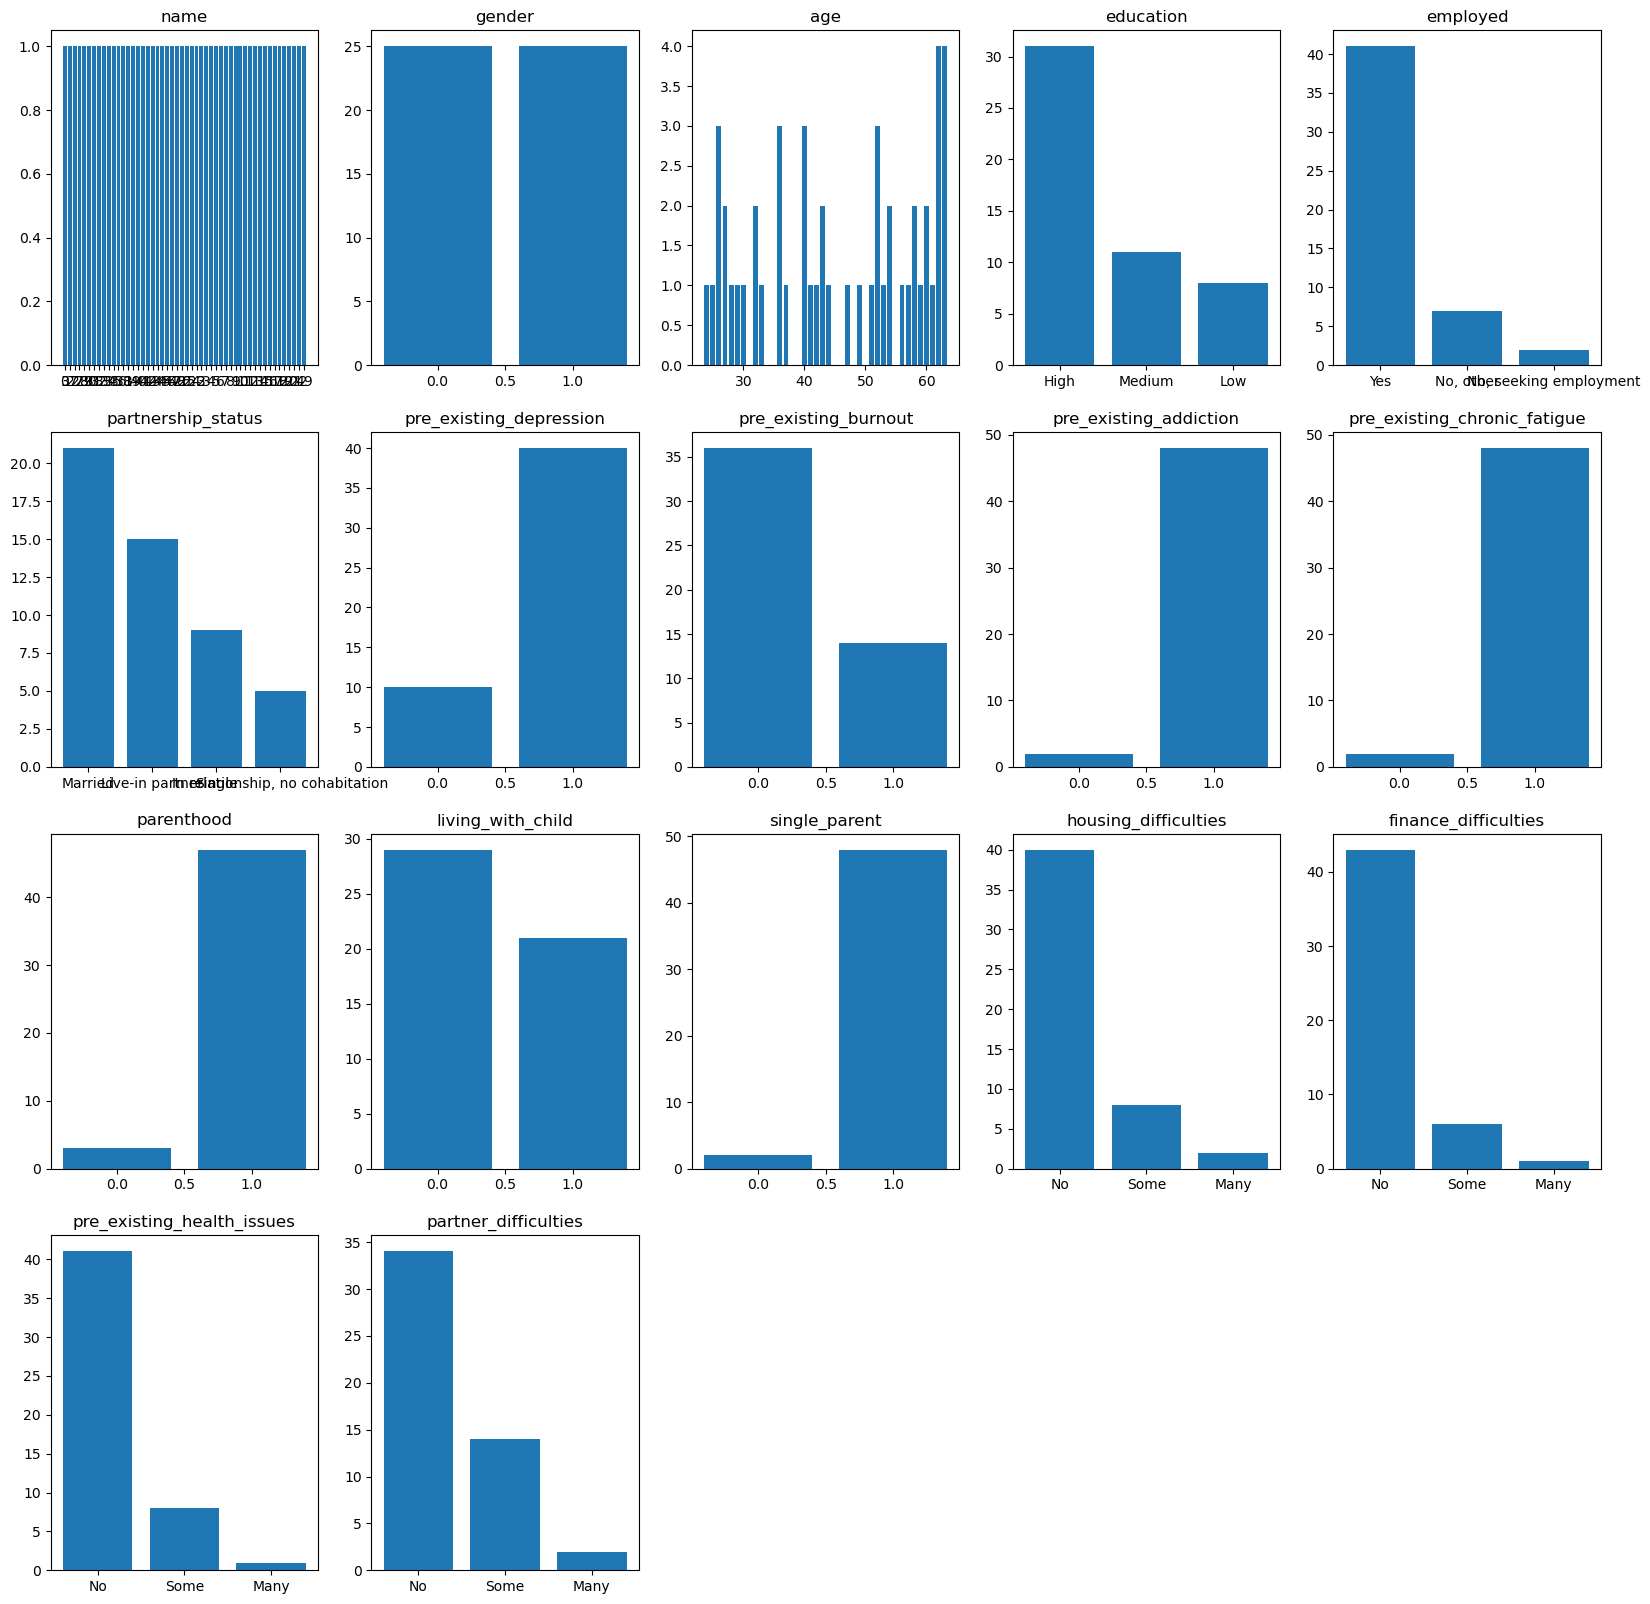

In [5]:
people.plot_summary()

We run a simple simulation whereby over 100 days (i.e., 100 steps), agents go to work (if employed), and generally socialise:

In [9]:
steps = 100

state_history = []
for step in range(steps):
    day_states = []
    for agent in people.population:
        
        if agent.state.employed:
            agent.go_to_work()
        
        agent.socialise()
        
        day_states.append(agent.state)
    
    state_history.append(day_states)
        
        
        

This will be their mental health (for example):

In [10]:
mh_employed = [s.mental_health for s in state_history[-1] if s.employed]
mh_unemployed = [s.mental_health for s in state_history[-1] if not(s.employed)]

In [11]:
print(np.mean(mh_employed))
print(np.mean(mh_unemployed))

402.0
302.0
